In [1]:
import torch
import numpy as np
from cryodrgn.source import ImageSource
import os
import pickle
import torch

dat = torch.load("../train_projections.pt")
ids = dat['ids']
images = dat['images']
phis = dat['phis']
thetas = dat['thetas']

dmat = torch.load("../siren_vols_distance_mat.pt")
dmat = dmat[:ids.shape[0], :ids.shape[0]]

/tmp/ipykernel_1386375/3222001592.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dat = torch.load("../train_projections.pt")
/tmp/ipykernel_1386375/3222001592.py:14: Fu

In [4]:
print(images.shape)
print(phis.shape)
print(thetas.shape)
print(ids.shape)
print(dmat.shape)

torch.Size([3500, 192, 128, 128])
torch.Size([3500, 192])
torch.Size([3500, 192])
torch.Size([3500])
torch.Size([3500, 3500])


In [5]:
import sys

sys.path.insert(1, "/nobackup/users/jamesron/broeyjoey/")
from data import ContrastiveProjectionDataset


dataset = ContrastiveProjectionDataset(images, phis, thetas, ids, dfu=[10000, 15000, 20000, 25000], snr1=[7.5,9,12, 15], pos_angle_threshold=45, obj_distance_matrix=dmat, pos_sim_threshold=0.4)
loader = torch.utils.data.DataLoader(dataset, collate_fn=lambda x: ContrastiveProjectionDataset.collate_fn(x, dataset.lat, dataset.mask, dataset.freqs, ctf_corrupt=False, noise=True), shuffle=True, batch_size=128)

(INFO) (lattice.py) (30-Mar-25 13:10:11) Using circular lattice with radius=64


In [6]:
imgs, ctf, _ids = next(iter(loader))

In [7]:
imgs.shape

torch.Size([128, 3, 128, 128])

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

def plot_projections(imgs, labels=None, max_imgs=25):
    if len(imgs) > max_imgs:
        imgs = imgs[:max_imgs]

    N = len(imgs)
    nrows = 1
    ncols = N

    fig, axes = plt.subplots(
        nrows=nrows, ncols=ncols, figsize=(1.5 * ncols, 1.5 * nrows)
    )

    if not isinstance(axes, np.ndarray):
        axes = np.array([[axes]])
    if labels is None:
        labels = [None for _ in axes.ravel()]

    for img, ax, lbl in zip(imgs, axes.ravel(), labels):
        ax.imshow(img, vmin=-15, vmax=15,cmap="Greys_r")
        if lbl is not None:
            ax.set_title(lbl)
        ax.axis("off")

    plt.tight_layout()
    return fig, axes



tensor([40281, 27735, 27879])


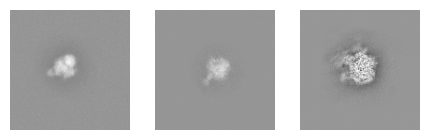

In [9]:
i=7
plot_projections(imgs[i])
print(_ids[i])

In [12]:
(_ids[:,0] != _ids[:,1]).sum() / 128

tensor(0.6016)

In [25]:
print(imgs.amax(dim=(-1,-2)))
print(imgs.amin(dim=(-1,-2)))
print(imgs.mean(dim=(-1,-2)))
print(imgs.std(dim=(-1,-2)))
print(imgs[...,0,0])

tensor([[22.2128, 15.0000, 18.1967],
        [ 9.3354, 10.8867,  4.9765],
        [20.5653,  7.9089, 13.0535],
        [13.8456,  8.1192, 14.0203],
        [15.0072, 17.8710, 10.7701],
        [10.5103,  5.6829, 14.6557],
        [ 3.5434,  4.6058,  5.4297],
        [15.0647, 13.9041,  9.1169]])
tensor([[-3.0423, -2.5843, -5.8024],
        [-1.7125, -1.9780, -2.2186],
        [-6.6047, -2.8212, -4.0613],
        [-2.9330, -1.2486, -1.9524],
        [-5.0227, -6.0817, -3.9054],
        [-0.5942, -0.5556, -1.4733],
        [-2.0567, -2.8409, -0.7753],
        [-4.0400, -1.8833, -1.1647]])
tensor([[-2.4253e-01, -3.2227e-03, -1.4064e-01],
        [-1.3948e-01, -1.7947e-02, -2.1139e-01],
        [ 1.8761e-01, -1.1286e-01,  1.7195e-03],
        [-8.5241e-02,  7.9488e-02,  1.7435e-01],
        [-2.7611e-04,  1.9887e-01, -2.3882e-01],
        [ 2.3283e-09,  1.8246e-02, -5.4812e-04],
        [ 9.3132e-10, -1.1392e-01,  8.0820e-02],
        [-5.4130e-03,  1.8752e-01,  7.2462e-02]])
tensor([[1.33

(<Figure size 750x150 with 5 Axes>,
 array([<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
        <AxesSubplot: >], dtype=object))

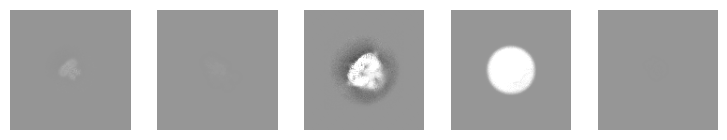

In [126]:
plot_projections(images[:5,0])

In [98]:
imgs_normed.amax(dim=(-1,-2))

tensor([[12.0000, 12.0000, 12.0000],
        [11.1723, 12.0000, 12.0000],
        [ 7.1187,  8.1715, 12.0000],
        [12.0000, 12.0000, 12.0000],
        [12.0000, 10.4475, 11.3687],
        [12.0000, 11.6809, 12.0000],
        [12.0000, 12.0000,  8.7224],
        [ 4.9007,  5.1741, 12.0000]])

In [15]:
from proj_search import optimize_theta_trans_chunked

from cryodrgn import shift_grid, so3_grid
trans = torch.tensor(shift_grid.base_shift_grid(0, 7, 7, xshift=0, yshift=0))
angles = torch.tensor(so3_grid.grid_s1(2), dtype=torch.float)

best_corr, best_indices = optimize_theta_trans_chunked(images.view([-1,128,128]), imgs[:,0].cuda(), trans.cuda(), angles, chunk_size=25, fast_translate=False, fast_rotate=True, refine_fast_translate=False)

(INFO) (lattice.py) (28-Feb-25 13:28:14) Using circular lattice with radius=64


In [16]:
best_indices

tensor([[613067,     23,      4],
        [545237,     41,     23],
        [192281,     42,     13],
        [454124,      2,     13],
        [231271,     46,      3],
        [253701,      0,      0],
        [628445,     11,     22],
        [452662,     27,     14]], device='cuda:0')

In [20]:
dat['ids'].unsqueeze(1).expand([-1,192]).reshape(-1)[best_indices[:,0].cpu()]

tensor([24490, 34897, 28557, 14813, 27904, 31620, 14546, 33111])

In [12]:
allids = torch.cat([pickle.load(open(f"../projection_chunks/{c}",'rb'))['ids'] for c in chunks])

In [21]:
ids

tensor([[24490, 24490, 34130],
        [34897, 34897, 29779],
        [15164, 15164, 24423],
        [26351, 26351, 28178],
        [27904, 27904, 14223],
        [31620, 31620, 33106],
        [14546, 14546, 27983],
        [33111, 33111, 33214]])

In [60]:
means = images.mean(dim=(0,1))

In [62]:
stds = images.std(dim=(0,1))

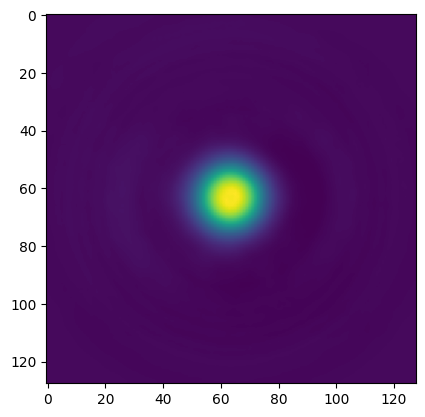

In [61]:
plt.imshow(means)

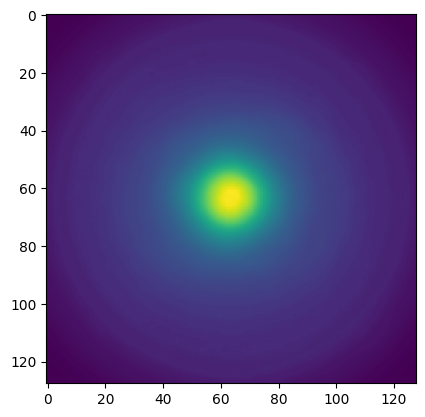

In [63]:
plt.imshow(stds)

In [120]:
images[2,0].min()

tensor(-5.0688)